# <font color='indigo'> Variational Quantum Eigensolver (VQE) in Pauli form </font>

Here we employ VQE to find the ground state of a Hamiltonian which is already in the form of linear combination of four Pauli matrices:
$\mathcal{H} = a X + b Y + c Z + d I$.

For Qiskit IBM documentation, visit:  https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

## Compare Qiskit's `NumPyEigensolver` with `numpy.linalg.eig`

In [2]:
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from random import random


# Define coefficients
a, b, c, d = 1, 2, 3, 4

# We can randomize the coefficients as well
scale = 10
a, b, c, d = scale*random(), scale*random(), scale*random(), scale*random()
a, b, c, d = round(a,2), round(b,2), round(c,2), round(d,2)

# Print the Hamiltonian with coeffcient avlues
print(f'H = aX + bY + cZ + dI where a = {a}, b ={b}, c = {c}, d = {d}')

# Construct Hamiltonian H = a*X + b*Y + c*Z + d*I using SparsePauliOp
H_op = SparsePauliOp.from_list([
    ("X", a),
    ("Y", b),
    ("Z", c),
    ("I", d)
])


# Convert to matrix for NumPy computation
H_matrix = H_op.to_matrix()
print('Hamiltonian in matrix form:',H_matrix)

# Method 1: Using NumPy's linear algebra module
eigenvalues_np, _ = np.linalg.eigh(H_matrix)
print("Eigenenergies (NumPy):", eigenvalues_np)

# Method 2: Using Qiskit's NumPyEigensolver
eigensolver = NumPyEigensolver(k=2)
result = eigensolver.compute_eigenvalues(H_op)
eigenvalues_qiskit = result.eigenvalues
print("Eigenenergies (Qiskit):", eigenvalues_qiskit)
#print("Imaginary parts (Qiskit):", eigenvalues_qiskit.imag)

# Compare results (accounting for possible different ordering)
# Find absolute differences for all possible pairings
diff1 = np.abs(eigenvalues_np - eigenvalues_qiskit)
diff2 = np.abs(eigenvalues_np - eigenvalues_qiskit[::-1])
difference = np.minimum(diff1, diff2)
###print("Absolute difference between NumPy and Qiskit results:", difference)

H = aX + bY + cZ + dI where a = 4.34, b =0.39, c = 7.66, d = 6.83
Hamiltonian in matrix form: [[14.49+0.j    4.34-0.39j]
 [ 4.34+0.39j -0.83+0.j  ]]
Eigenenergies (NumPy): [-1.98267837 15.64267837]
Eigenenergies (Qiskit): [-1.98267837 15.64267837]


## Now let's solve the same Hamiltonian using VQE

In [19]:
#!pip install qiskit-algorithms --upgrade
#from qiskit_algorithms import VQE
#from qiskit_algorithms.minimum_eigensolvers import VQE
#from qiskit_aer.primitives import Estimator  # Use the Primitive Estimator
from qiskit.circuit.library import EfficientSU2
#from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit.primitives import BaseEstimatorV2, EstimatorPubLike, PrimitiveResult, PubResult, DataBin
from qiskit.primitives.containers.estimator_pub import EstimatorPub
from qiskit.primitives.containers.object_array import object_array

In [ ]:
# === VQE Setup ===
# Step 1: Ansatz
ansatz = EfficientSU2(H_op.num_qubits, entanglement="linear")
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters
print('No. of parameters in ansatz:',num_params)

# Step 2: Measurement (expectation value)
estimator = Estimator() 
                # Primitive Estimator (you may get warning)
    
# Step 3: Optimization of expectation value    
#optimizer = SPSA(maxiter=100) 
optimizer = COBYLA(maxiter=100)

# Now VQE
vqe = VQE(
    estimator=estimator,  
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.random.rand(ansatz.num_parameters)
)

vqe_result = vqe.compute_minimum_eigenvalue(H_op)
print("VQE Eigenvalue:", vqe_result.eigenvalue)


(4x4) Hamiltonian
[[ 0.    0.   -0.5   0.  ]
 [ 0.    0.75 -0.5   0.  ]
 [-0.5  -0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.  ]]

Qubit Op Eigenvalues:
 [-0.75  0.    0.25  1.  ]


/var/folders/3m/pc44t30x60gd3bj_3f670_yw0000gn/T/ipykernel_21461/1493103567.py:30: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Primitive Estimator instead of Aer backend


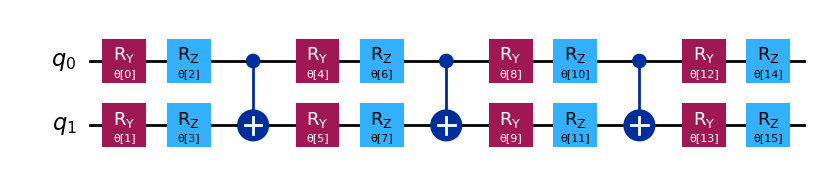

VQE Eigenvalue: -0.7495952100950853


In [2]:
import numpy as np
from qiskit_algorithms import VQE, NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator  # Use the Primitive Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import SPSA

# Constants and Hamiltonian construction (same as before)
c1, c2, c3 = -0.5, 0.75, 2.0
n2 = 4
Hamil_4x4 = np.zeros((n2, n2))
Hamil_4x4[1,1] = c2
Hamil_4x4[2,2] = -c3/2 + c2
Hamil_4x4[[0,1,2], [2,2,0]] = c1
Hamil_4x4[2,1] = c1

print("\n(4x4) Hamiltonian")
print(Hamil_4x4)

# Convert to quantum operator
Hamil_Qop = SparsePauliOp.from_operator(Hamil_4x4)

# Exact solver (replaces NumPyEigensolver.run())
exact_solver = NumPyEigensolver(k=4)
exact_result = exact_solver.compute_eigenvalues(Hamil_Qop)
print("\nQubit Op Eigenvalues:\n", exact_result.eigenvalues)


# === VQE Setup ===
estimator = Estimator()  # Primitive Estimator instead of Aer backend
optimizer = SPSA(maxiter=100)
ansatz = EfficientSU2(Hamil_Qop.num_qubits, entanglement="linear") 
display(ansatz.decompose().draw("mpl", style="iqp"))


vqe = VQE(
    estimator=estimator,  # Use the Primitive Estimator
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.random.rand(ansatz.num_parameters)
)

vqe_result = vqe.compute_minimum_eigenvalue(Hamil_Qop)
print("VQE Eigenvalue:", vqe_result.eigenvalue)

### Optimize through ISA circuits
To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target QPU (referred to as instruction set architecture (ISA) circuits and observables).

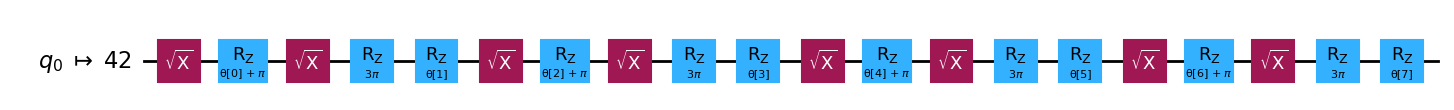

In [62]:
x0

array([1.38696931, 3.73842881, 3.57548501, 0.4758309 , 1.48644264,
       1.35757732, 5.06452395, 1.15582661])

### Execute through runtime Estimator

In [63]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

qiskit_runtime_service.check_pending_jobs:WARNING:2025-04-14 03:15:56,034: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('cykvy9101rbg008gek8g', 'estimator')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'409 Client Error: Conflict for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"You have reached the limit of 3 pending  jobs. Please wait for a job to complete or cancel one before submitting anything new.","code":3458,"solution":"Wait until some previous jobs were finished. You can cancel pending jobs to run new jobs.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
res

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

### Plot progress through call history

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()


(4x4) Hamiltonian
[[ 0.    0.   -0.5   0.  ]
 [ 0.    0.75 -0.5   0.  ]
 [-0.5  -0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.  ]]

Qubit Op Eigenvalues:
 [-0.75  0.    0.25  1.  ]


/var/folders/3m/pc44t30x60gd3bj_3f670_yw0000gn/T/ipykernel_35992/1493103567.py:30: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Primitive Estimator instead of Aer backend


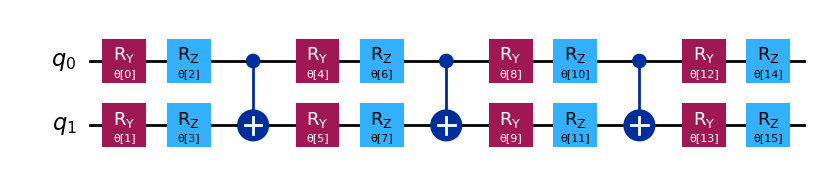

VQE Eigenvalue: -0.7472000421206602


In [1]:
import numpy as np
from qiskit_algorithms import VQE, NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator  # Use the Primitive Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import SPSA

# Constants and Hamiltonian construction (same as before)
c1, c2, c3 = -0.5, 0.75, 2.0
n2 = 4
Hamil_4x4 = np.zeros((n2, n2))
Hamil_4x4[1,1] = c2
Hamil_4x4[2,2] = -c3/2 + c2
Hamil_4x4[[0,1,2], [2,2,0]] = c1
Hamil_4x4[2,1] = c1

print("\n(4x4) Hamiltonian")
print(Hamil_4x4)

# Convert to quantum operator
Hamil_Qop = SparsePauliOp.from_operator(Hamil_4x4)

# Exact solver (replaces NumPyEigensolver.run())
exact_solver = NumPyEigensolver(k=4)
exact_result = exact_solver.compute_eigenvalues(Hamil_Qop)
print("\nQubit Op Eigenvalues:\n", exact_result.eigenvalues)


# === VQE Setup ===
estimator = Estimator()  # Primitive Estimator instead of Aer backend
optimizer = SPSA(maxiter=100)
ansatz = EfficientSU2(Hamil_Qop.num_qubits, entanglement="linear") 
display(ansatz.decompose().draw("mpl", style="iqp"))


vqe = VQE(
    estimator=estimator,  # Use the Primitive Estimator
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.random.rand(ansatz.num_parameters)
)

vqe_result = vqe.compute_minimum_eigenvalue(Hamil_Qop)
print("VQE Eigenvalue:", vqe_result.eigenvalue)

In [2]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila

# Use a fake backend with noise model
fake_backend = FakeManila()
noisy_simulator = AerSimulator.from_backend(fake_backend)

with Session(service=service, backend=noisy_simulator) as session:
    estimator = RuntimeEstimator(session=session)

ImportError: cannot import name 'FakeManila' from 'qiskit.providers.fake_provider' (/usr/local/lib/python3.11/site-packages/qiskit/providers/fake_provider/__init__.py)

In [21]:
from qiskit_algorithms.minimum_eigensolvers import VQE


ImportError: cannot import name 'BaseSampler' from 'qiskit.primitives' (/usr/local/lib/python3.11/site-packages/qiskit/primitives/__init__.py)

In [24]:
import qiskit_algorithms
#module_dict = qiskit_algorithms.__dict__
#print(module_dict)

ImportError: cannot import name 'BaseSampler' from 'qiskit.primitives' (/usr/local/lib/python3.11/site-packages/qiskit/primitives/__init__.py)